# Training Set Generator

Generates 20.000 synthetic formation tests to use as the training set

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../")
import RadialStorage
from CaseGenerator import CaseGenerator
from Utilities import calc_derivative

### Available models

In [2]:
models = [
    "infinite", 
    "1 barrier", 
    "corner", 
    "channel", 
    "u shaped", 
    "closed", 
    "radial storage"
]

### Case generation function

Randomizes several parameters and builds one of the selected models

In [4]:
def gen_case():
    n_grids = 41
    rw = 0.108
    q_ref = 15.9
    k    = np.random.uniform(50, 1000)
    por  = 0.2   # np.random.uniform(0.1, 0.3)
    h    = np.random.uniform(10, 300)
    ct   = 1e-5  # np.random.uniform(1e-6, 1e-5)
    Bo   = np.random.uniform(1, 2)
    visc = 1     # np.random.uniform(0.5, 2.0)
    stor = np.random.uniform(1,500)/100
    skin = np.random.uniform(-2, 5)
    L1, L2, L3, L4 = (1000000, 1000000, 1000000, 1000000)
    q = np.random.uniform(100,1000)

    model = np.random.choice(models)
    if model == "1 barrier":
        L1 = np.random.uniform(10, 250)
    elif model == "corner":
        L1 = np.random.uniform(10, 250)
        L2 = np.random.uniform(10, 250)
    elif model == "channel":
        L1 = np.random.uniform(10, 250)
        L3 = np.random.uniform(10, 250)
    elif model == "u shaped":
        L1 = np.random.uniform(10, 250)
        L2 = np.random.uniform(10, 250)
        L3 = np.random.uniform(10, 250)
    elif model == "closed":
        L1 = np.random.uniform(10, 250)
        L2 = np.random.uniform(10, 250)
        L3 = np.random.uniform(10, 250)
        L4 = np.random.uniform(10, 250)

    t_max = np.random.uniform(1,3)
    tk = np.logspace(-2.2,t_max+0.2,22)

    if model == "radial storage":
        dp_u = RadialStorage.calc_press(tk, k, por, h, ct, Bo, visc, q, skin, stor, rw)
    else:
        case = CaseGenerator(tk, k, por, h, ct, Bo, visc, q, skin, L1, L2, L3, L4, rw)
        dp_u = case.create_dpu()
    der_u = calc_derivative(tk, dp_u/q_ref, 0.0)

    tk = tk[1:-1]
    dp_u = dp_u[1:-1]
    der_u = der_u[1:-1]
    result = f"{model},{k},{por},{h},{ct},{Bo},{visc},{q},{skin},{stor},{L1},{L2},{L3},{L4},{rw},"
    result += ",".join([f"{x}" for x in tk]) + ","
    result += ",".join([f"{x}" for x in dp_u]) + ","
    result += ",".join([f"{x}" for x in der_u]) + "\n"
    return result, tk, dp_u, der_u

### Single case test

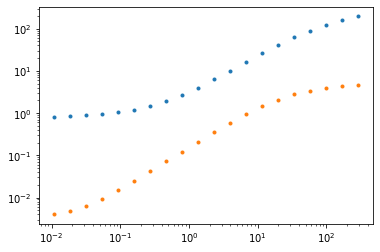

In [5]:
data, tk, dp_u, der_u = gen_case()
plt.loglog(tk, dp_u, ".")
plt.loglog(tk, der_u, ".")

### 20000 cases generation

Cases are generated in 1000 increments to avoid memory overflow

In [ ]:
if "generated" not in os.listdir():
    os.mkdir("generated")

header = "model,k,por,h,ct,Bo,visc,q,skin,stor,L1,L2,L3,L4,rw"
header += "".join([f",t{i}" for i in range(20)])
header += "".join([f",dp{i}" for i in range(20)])
header += "".join([f",derp{i}" for i in range(20)]) + "\n"

np.random.seed(100)
for i in range(20):
    lines = []
    for x in range(1000):
        data, tk, dp_u, der_u = gen_case()
        lines.append(data)
    with open(f"generated/output_{i}.csv", "w") as f:
        f.write(header)
        f.writelines(lines)

### Unifying all generated output files

Unifies all files in the generated folder into a single `tests_input.csv` file

In [114]:
import os
all_lines = []
for i,filename in enumerate(os.listdir("generated")):
    with open(f"generated/{filename}") as f:
        lines = f.readlines()
        if i != 0:
            lines = lines[1:]
        all_lines += lines

with open("tests_input.csv", "w") as f:
    f.writelines(all_lines)